In [50]:
import numpy as np
import torch
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib notebook
import json
import os
from Dataset_Utils import BraTS_TrainingDataset
from Dataset_Utils import BraTS_TestDataset
from Dataset_Utils import plot_batch
from matplotlib.animation import FuncAnimation
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from unet_short import UNet
from matplotlib import cm

In [2]:
# PATH
dataset_path = '../Task01_BrainTumour/cropped'

train_data = BraTS_TrainingDataset(dataset_path, 30, 42)
test_data = BraTS_TestDataset(dataset_path, 30, 42)

../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr
../Task01_BrainTumour/cropped\imagesTr
../Task01_BrainTumour/cropped\labelsTr


In [3]:
trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=20, shuffle=True)

testloader = torch.utils.data.DataLoader(
    test_data, batch_size=20, shuffle=True)

train_iter = iter(trainloader)
test_iter = iter(testloader)

In [4]:
sample_batch = test_iter.next()
print(sample_batch['image'].shape)
print(sample_batch['label'].shape)
# plot_batch(sample_batch, num_rows=2, height=75)

torch.Size([20, 4, 155, 192, 192])
torch.Size([20, 1, 155, 192, 192])


In [21]:
device = 'cuda:0'
unet_loaded = UNet(in_channels=4, out_channels=4, init_features=32)
unet_loaded.load_state_dict(torch.load('../Saved_Models/model_weights_0'))
_ = unet_loaded.to(device)

In [26]:
batch_slices = sample_batch['image']
prediction = np.zeros((155, 20, 4, 192, 192))
for i in range(155):
    batch_slice = batch_slices[:, :, i, :, :].to(device)
    output = unet_loaded(batch_slice)
    prediction[i] = torch.round(torch.sigmoid(output[0])).detach().cpu().numpy()
print(prediction.shape)
print(output.shape)

(155, 20, 4, 192, 192)
torch.Size([20, 4, 192, 192])


# 2D Animation

In [45]:
def animate(i):
    axs[0,0].clear()
    axs[0,0].title.set_text('image')
    axs[0,0].imshow(sample_batch['image'][0,0,i,:,:], cmap="gray", origin="lower")
    axs[0,1].clear()
    axs[0,1].title.set_text('label')
    axs[0,1].imshow(sample_batch['label'][0,0,i,:,:], cmap="gray", origin="lower")
    axs[0,2].clear()
    axs[0,2].title.set_text('prediction_1')
    axs[0,2].imshow(prediction[i,0,0,:,:], cmap="gray", origin="lower")
    axs[1,0].clear()
    axs[1,0].title.set_text('prediction_2')
    axs[1,0].imshow(prediction[i,0,1,:,:], cmap="gray", origin="lower")
    axs[1,1].clear()
    axs[1,1].title.set_text('prediction_3')
    axs[1,1].imshow(prediction[i,0,2,:,:], cmap="gray", origin="lower")
    axs[1,2].clear()
    axs[1,2].title.set_text('prediction_4')
    axs[1,2].imshow(prediction[i,0,3,:,:], cmap="gray", origin="lower")

<IPython.core.display.Javascript object>


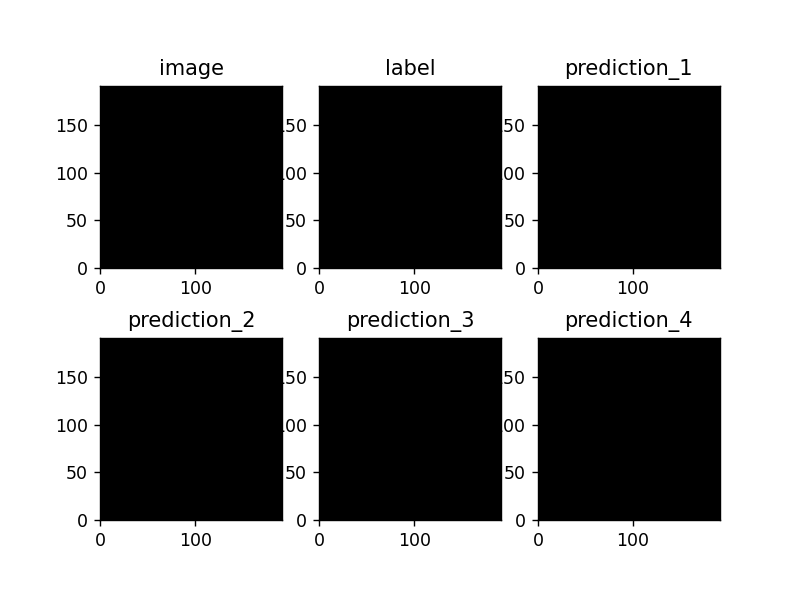

In [92]:
fig, axs = plt.subplots(2, 3)
ani = FuncAnimation(fig, animate, frames=155, interval=50, repeat=False)

plt.show()

# 3D Visualization

In [86]:
cube = sample_batch['label'][0, 0]

In [87]:
# taken from https://terbium.io/2017/12/matplotlib-3d/
IMG_DIM = 40

from skimage.transform import resize
resized = resize(cube, (IMG_DIM, IMG_DIM, IMG_DIM), mode='constant')

In [90]:
def plot_cube(cube, angle=320):        
    filled = cube != 0
    
    x, y, z = np.indices(np.array(filled.shape) + 1)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection='3d')
    ax.view_init(30, angle)
    ax.set_xlim(right=IMG_DIM*2)
    ax.set_ylim(top=IMG_DIM*2)
    ax.set_zlim(top=IMG_DIM*2)
    
    ax.voxels(x, y, z, filled, facecolors=cm.viridis(cube), shade=False)
    plt.show()

<IPython.core.display.Javascript object>


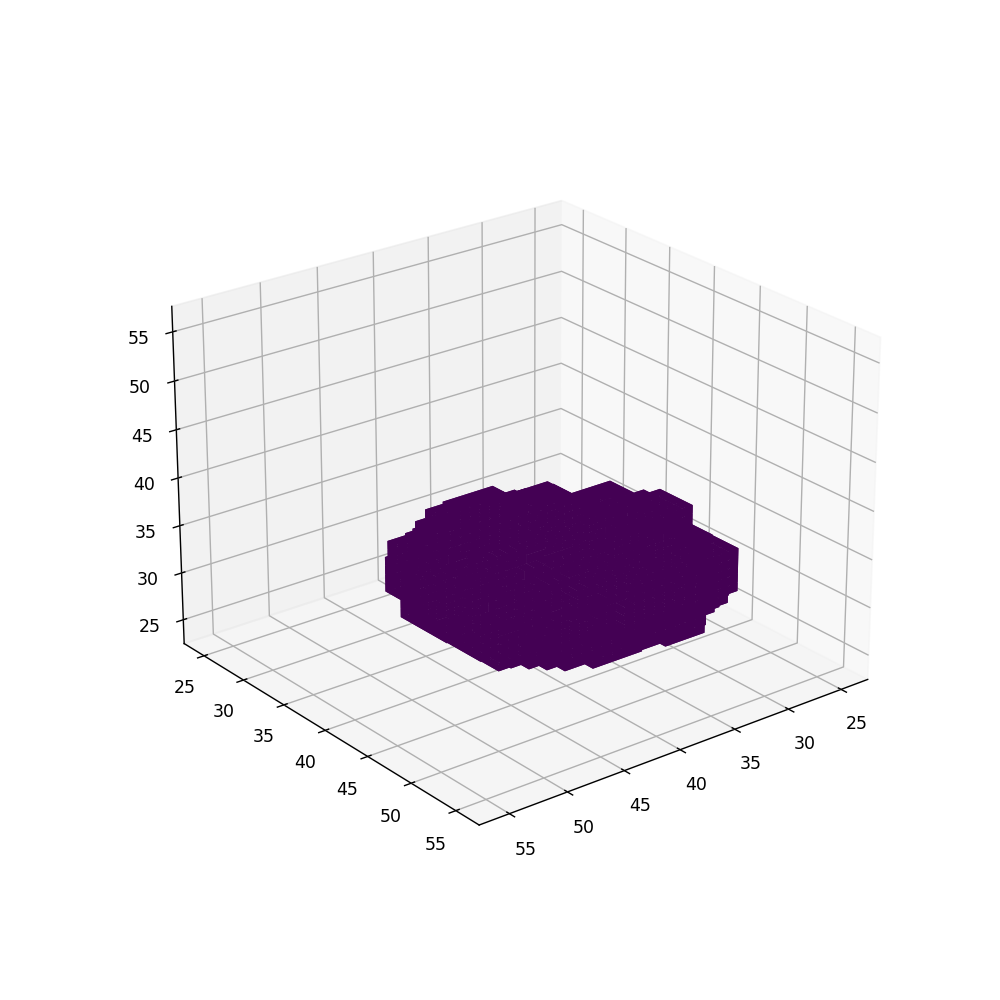

In [91]:
plot_cube(resized)